# initilise the search space


Notebook showing how we can define the search space with conditions

In [9]:

import os
#os.chdir('c:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH\\')
os.chdir('/rds/general/user/ma11115/home/STK_Search/STK_search')

from stk_search import Searched_space
import importlib
importlib.reload(Searched_space)
import pickle
import pymongo
import pandas as pd
import numpy as np
from stk_search.utils import database_utils


In [10]:
# load the data and the precursors dataset
importlib.reload(database_utils)
df_total_path = "data/output/Full_dataset/New_target07052024.csv"
df_precursors_path ="data/output/Prescursor_data/precursor_data_200324.pkl"
df_properties_path = "data/input/Prescursor_data/df_properties_10052024.pkl"
df_precursors_path ="data/output/Prescursor_data/precursor_data_new_clustering.pkl"

df_total_new , df_precursors= database_utils.load_data_from_file(df_total_path, df_precursors_path,add_feature_frag=True)

/rds/general/user/ma11115/home/STK_Search/STK_search/src/stk_search/utils/database_utils.py:111: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_total = pd.read_csv(df_path)


In [11]:
def check_mol(mol):
    if mol.GetNumAtoms()>=30:
        return 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() ==14:
            return 0
        if atom.GetAtomicNum() ==32:
            return 0
    return 1
df_precursors['check'] = df_precursors['mol_opt'].apply(check_mol)
df_precursors = df_precursors[df_precursors['check']==1]
df_precursors.drop(columns=['check'], inplace=True)
df_precursors.shape

(274, 49)

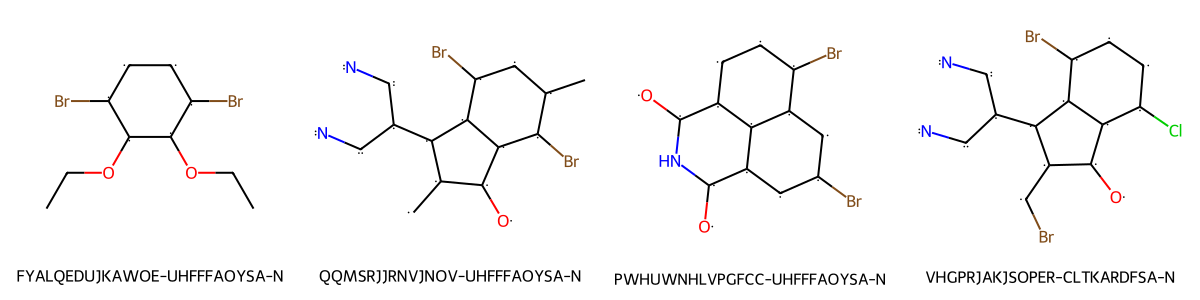

In [12]:
# plot some example of precursors
from rdkit.Chem import Draw
from rdkit import Chem
mol_list = []
mol_label = []
df_to_plot = df_precursors.sample(4)
df_to_plot['mol_opt_smiles'] = df_to_plot['mol_opt'].apply(lambda x : Chem.MolFromSmiles(Chem.MolToSmiles(x)))
mol_list.extend(df_to_plot['mol_opt_smiles'].values)
mol_label.extend(df_to_plot['InChIKey'].values)
# Draw molecules
img = Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(300, 300),legends=[f"{label}" for label in mol_label])  # adjust molsPerRow and subImgSize as needed
img




In [13]:
#%%  generate the search space

number_of_fragments = 6
target_name = 'target' # specify the target name ( here target refers to the combined property)
aim = 1.0 # specify the target value

SP = Searched_space.Searched_Space(number_of_fragments=number_of_fragments,df=df_precursors,features_frag=df_precursors.columns[0:1],generation_type='conditional')
print(SP.features_frag)
SP.generate_interactive_condition_V2(df_total=df_total_new)

Index(['InChIKey'], dtype='object')


space size  423158800038976
1


[[], [], [], [], [], []]
[{'number of elements': 423158800038976, 'syntax': [0, 1, 2, 3, 4, 5], 'conditions': [[], [], [], [], [], []], 'Elements in top 5%': 0, 'number of elements evaluated': 0}, {'number of elements': 423158800038976, 'syntax': [0, 1, 2, 3, 4, 5], 'conditions': [[], [], [], [], [], []], 'Elements in top 5%': '5.331510594668489', 'number of elements evaluated': '3.80e+04'}]


In [14]:
import glob
#%% 

search_spaces_dfs = glob.glob('data/*pkl')
for id,df_path_SP in enumerate(search_spaces_dfs):
    print(id,df_path_SP)


0 data/search_space_properties_2024_03_26_22_35_59.pkl
1 data/search_space_properties_2024_03_26_22_47_54.pkl
2 data/search_space_properties_2023_09_11_12_03_15.pkl
3 data/search_space_properties.pkl
4 data/search_space_properties_2024_02_04_19_33_02.pkl
5 data/search_space_properties_2024_02_14_16_49_52.pkl
6 data/search_space_properties_2023_12_19_11_56_13.pkl
7 data/search_space_properties_2024_03_26_22_54_01.pkl
8 data/search_space_properties_2023_10_30_16_20_54.pkl


In [15]:
df_SP = pd.read_pickle(search_spaces_dfs[3])
df_SP.reset_index(drop=True,inplace=True)
df_SP

,number of elements,syntax,conditions,Elements in top 5%,number of elements evaluated
0,32894113444921,"[0, 1, 2, 3, 4, 5]","[[], [], [], [], [], []]",0,0


In [16]:
# load the saved dataframe with all the tested conditions
# and output it in order to select a few to add to the bactk experiment

import pickle
from datetime import datetime
import os

def save_SP_for_EXP(df:pd.DataFrame,index_list:list,exp_name:str,number_of_fragments):
    time_now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    save_dir = f'data/input/EXP_search_space/{exp_name}_{time_now}/'
    os.makedirs(save_dir,exist_ok=True)
    SP = Searched_space.Searched_Space(number_of_fragments=number_of_fragments,df=df_precursors,features_frag=df_precursors.columns[0:1],generation_type='conditional')
    SP.features_frag=SP.features_frag.append(df_precursors.columns[17:23])
    SP.features_frag=SP.features_frag.append(df_precursors.columns[1:7])

    for id in index_list:
        SP.conditions_list = df['conditions'].values[id]
        SP.syntax = list(df['syntax'].values[id])[:number_of_fragments]
        SP.redefine_search_space()
        print(f"{SP.space_size:.2e}")
        print(SP.syntax)
        print(SP.conditions_list)
        pickle.dump(SP,file=open(save_dir+f'/search_space_{id}.pkl','wb'))
        print(' saved to ', save_dir+f'/search_space_{id}.pkl')
    return SP, save_dir
experiment_name = '6_mers_filtered_BB'
SP,save_dir= save_SP_for_EXP(df_SP,[0],experiment_name,number_of_fragments)

space way too big
4.23e+14
[0, 1, 2, 3, 4, 5]
[[], [], [], [], [], []]
 saved to  data/input/EXP_search_space/6_mers_filtered_BB_2024_05_15_09_28_21//search_space_0.pkl


In [20]:

print(f"{306**6:.2e}")

8.21e+14


In [21]:
df_precursors.shape

(274, 49)